# Classifying-Song-Genres-from-Audio-Data

In the Classify Song Genres machine learning project, you will be using the song dataset to classify songs into two categories: 'Hip-Hop' or 'Rock.' You will check the correlation between features, normalize data using scikit-learn’s StandardScaler, apply PCA (Principal Component Analysis) on scaled data, and visualize the results. 

After that, you will use the scikit-learn Logistic Regression and Decision Tree model to train and validate the results. In this project, you will also learn some of the advanced techniques such as class balancing and cross-validation to reduce model bias and overfitting. 

In [1]:
import pandas as pd

1.To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as danceability and acousticness on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.

Let's start by creating two pandas DataFrames out of these files that we can merge so we have features and labels (often also referred to as X and y) for the classification later on.

In [2]:
tracks = pd.read_csv(r"C:\Users\hp\Documents\GG Imarticus\CapstoneProject\fma-rock-vs-hiphop.csv")

In [3]:
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [12]:
echonest_metrics = pd.read_json(r"C:\Users\hp\Documents\GG Imarticus\CapstoneProject\echonest-metrics.json",precise_float=True)
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [13]:
echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id')
print(echo_tracks.head())

   track_id  acousticness  danceability    energy  instrumentalness  liveness  \
0         2      0.416675      0.675894  0.634476          0.010628  0.177647   
1         3      0.374408      0.528643  0.817461          0.001851  0.105880   
2         5      0.043567      0.745566  0.701470          0.000697  0.373143   
3       134      0.452217      0.513238  0.560410          0.019443  0.096567   
4       153      0.988306      0.255661  0.979774          0.973006  0.121342   

   speechiness    tempo   valence genre_top  
0     0.159310  165.922  0.576661   Hip-Hop  
1     0.461818  126.957  0.269240   Hip-Hop  
2     0.124595  100.260  0.621661   Hip-Hop  
3     0.525519  114.290  0.894072   Hip-Hop  
4     0.051740   90.241  0.034018      Rock  


2. Pairwise relationships between continuous variables
We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:

To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).
When our datasets are very large, using fewer features can drastically speed up our computation time.
To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the pandas package.

In [15]:
numeric_columns = echo_tracks.select_dtypes(include=['float64', 'int64'])
corr_metrics = numeric_columns.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


3. Normalizing the feature data
As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).

It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

In [16]:
# Define our features 
features = echo_tracks.drop(columns=['genre_top','track_id'],axis=1)

# Define our labels
labels = echo_tracks.loc[:,'genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

4. Principal Component Analysis on our scaled data
Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.

Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.

Text(0.5, 0, 'Principal Component #')

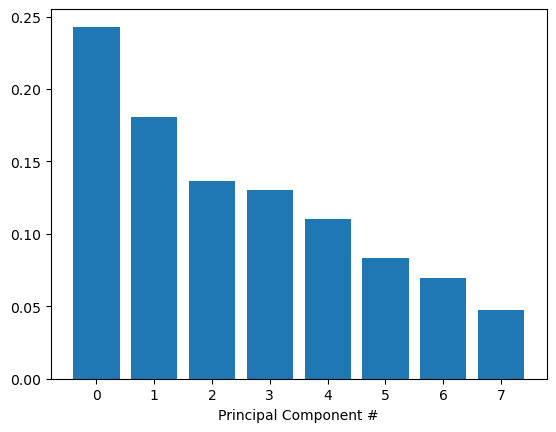

In [17]:
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
fig, ax = plt.subplots()
ax.bar(range((len(exp_variance))), exp_variance)
ax.set_xlabel('Principal Component #')

5. Further visualization of PCA
Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

But all is not lost! Instead, we can also look at the cumulative explained variance plot to determine how many features are required to explain, say, about 90% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

[0.24297674 0.4234199  0.55992299 0.68986388 0.80042636 0.88344881
 0.95268664 1.        ]


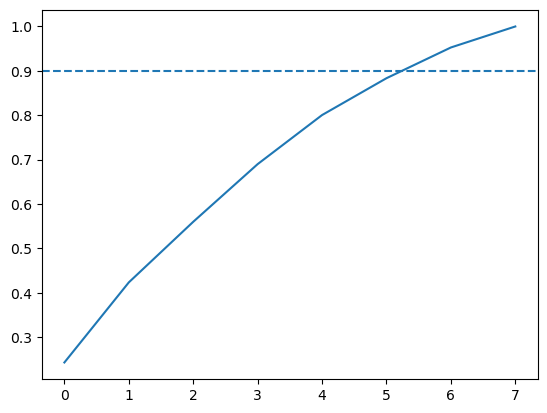

In [18]:
import numpy as np

cum_exp_variance = np.cumsum(exp_variance)
print(cum_exp_variance)
# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 6


pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)


6. Train a decision tree to classify genre
Now we can use the lower dimensional PCA projection of the data to classify songs into genres. To do that, we first need to split our dataset into 'train' and 'test' subsets, where the 'train' subset will be used to train our model while the 'test' dataset allows for model performance validation.

Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.

Here is an example of a decision tree that demonstrates the process by which an input image (in this case, of a shape) might be classified based on the number of sides it has and whether it is rotated.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels,random_state=10)

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)

pred_labels_tree = tree.predict(test_features)

In [20]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)


In [22]:
from sklearn.metrics import classification_report

class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)


Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



8. Balance our data for greater performance
Both our models do similarly well, boasting an average precision of 87% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.

Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in sample size of our data points when weighting our classes here, and not relative importance of each class.

In [24]:
hop_only = echo_tracks.loc[echo_tracks['genre_top']=='Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top']=='Rock']

rock_only = rock_only.sample(910,random_state=10)

rock_hop_bal = pd.concat([rock_only,hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels, random_state=10)

9. Does balancing our dataset improve model bias?
We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance.

Note that we have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.

In [25]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)
pred_labels_tree = tree.predict(test_features)

logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

print("Decision Tree: \n", classification_report(pred_labels_tree,test_labels))
print("Logistic Regression: \n", classification_report(pred_labels_logit,test_labels))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.73      0.74      0.74       228
        Rock       0.74      0.73      0.73       227

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.84      0.82       217
        Rock       0.85      0.80      0.83       238

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



10. Using cross-validation to evaluate our models
Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called cross-validation (CV). This step allows us to compare models in a more rigorous fashion.

Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as K-fold CV here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.

In [27]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree,pca_projection,labels,cv=kf)
logit_score = cross_val_score(logreg,pca_projection,labels,cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7489010989010989 Logistic Regression: 0.782967032967033
